# 參數設定 (使用訊號分解 EMD)

In [1]:
import os

labels = ['GroupCount']
model_type = 4 # 使用模型
predicteds = [5] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = True # 是否使用 EMD，False 則使用 EEMD 
 
model_dir = 'DecompEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: DecompEMD/_Model/GroupCount_mt4_data5_batch14.x_scaler.pkl
y_scaler_file_name: DecompEMD/_Model/GroupCount_mt4_data5_batch14.y_scaler.pkl
model_file_name: DecompEMD/_Model/GroupCount_mt4_data5_batch14.model.keras
result_file_name: DecompEMD/_Model/GroupCount_mt4_data5_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[5],156009964,1063367,873569,9,2531,64,2604,0,0,0,0,0,0,2604
1,2023-04-03,[5],266983699,1670644,1289435,33,3928,75,4034,2,0,0,0,0,0,4036
2,2023-04-04,[5],198064713,1377806,881103,8,3552,72,3630,2,0,0,0,0,0,3632
3,2023-04-05,[5],275355693,1804631,1005218,8,4270,101,4378,1,0,0,0,0,0,4379
4,2023-04-06,[5],226168175,2059599,1254506,40,5491,82,5612,0,0,0,1,0,0,5613


# 訊號分解

# 訊號分解
EMD
IMFs shape : (7, 395)
eIMFs shape : (6, 395)
residue shape : (395,)


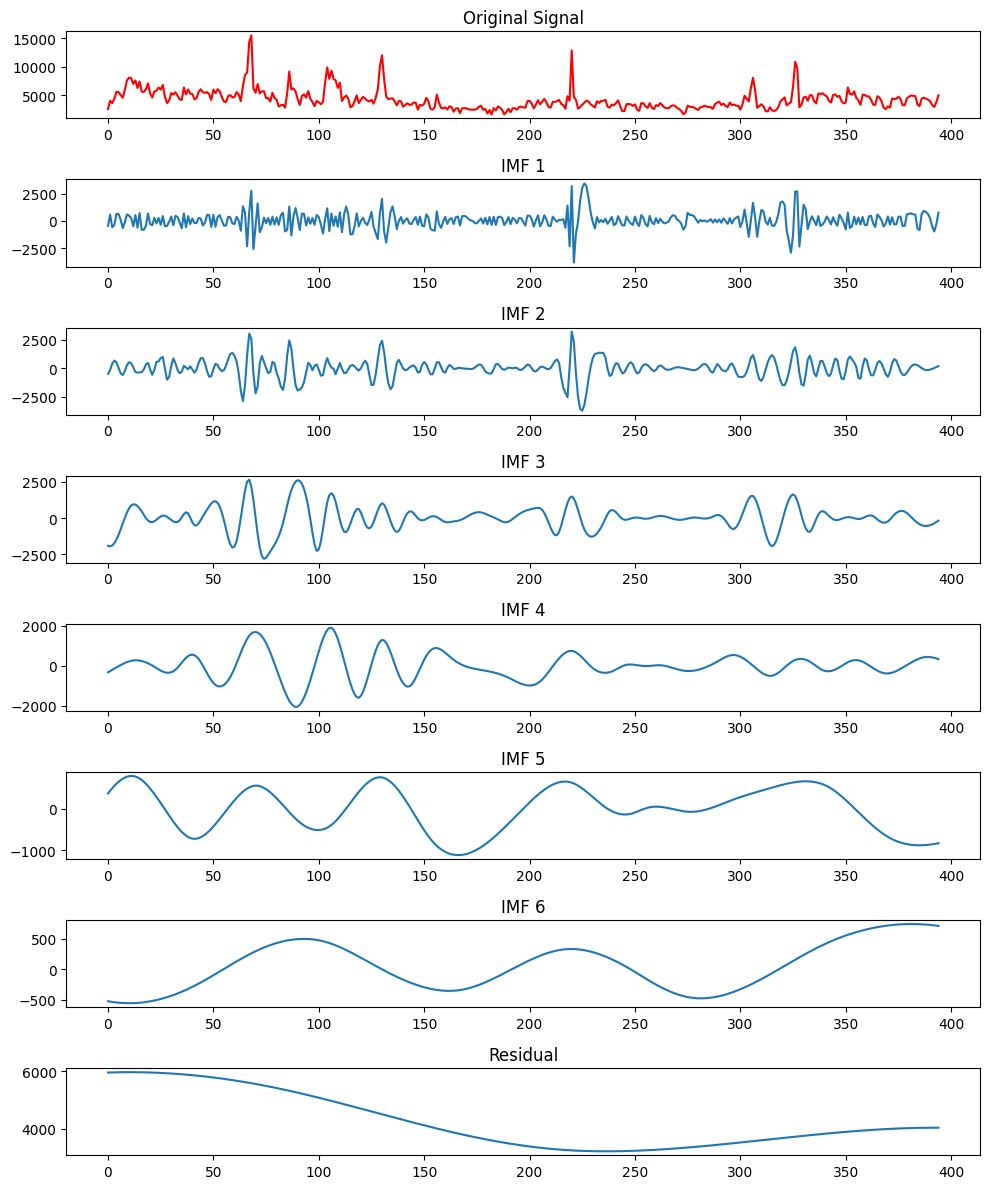

In [5]:
data_source = df_source[labels].values
eIMFs, residue, imfs = lstm.decomposition(data_source, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [6]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
----------------------------------------------------------------

# 最小最大正規化

In [7]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [8]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [9]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [10]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：4
CNN-BiLSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 200)                 │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,372 (544.42 KB)

 Trainable params: 139,372 (544.42 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [11]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [12]:
for i in range(len(models)):
    print_step(i + 1)   

    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt4_data5_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt4_data5_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt4_data5_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEMD/_Model/GroupCount_mt4_data5_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-----------------------------

# 預測

In [13]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [14]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [15]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(data_source, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (301, 1)
y_lstm_origin_train.shape : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14, 1)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14, 1)
y_lstm_origin_val.shape : (24, 1)


In [16]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (301, 1)
actual_inverse_train_sum (301, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [17]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_absolute_percentage_error: 9.8638

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100 - mean_absolute_percentage_error: 822768.3750


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.07064，MAPE:7324579793896.325，MSE:0.00966，RMSE:0.0983，R square:0.15309
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:514.90006，MAPE:6.96326，MSE:513469.52687，RMSE:716.56788，R square:0.15309

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mean_absolute_percentage_error: 10.0205

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_absolute_percentage_error: 10.0205


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.0546，MAPE:0.1002，MSE:0.00483，RMSE:0.0695，R square:-0.09662
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:397.96368，MAPE:1.39859，MSE:256669.09944，RMSE:506.62521，R square:-0.09662

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mean_absolute_percentage_error: 14.3589

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mean_absolute_percentage_error: 14.3589


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.08056，MAPE:0.14359，MSE:0.00819，RMSE:0.09047，R square:-0.30222
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:587.24935，MAPE:1.03783，MSE:434919.82125，RMSE:659.48451，R square:-0.30222

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - mean_absolute_percentage_error: 10.3013

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - mean_absolute_percentage_error: 272025.1562


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.05992，MAPE:2421571632335.667，MSE:0.00833，RMSE:0.09129，R square:0.47346
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:415.56676，MAPE:2.06992，MSE:400820.68501，RMSE:633.10401，R square:0.47346

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mean_absolute_percentage_error: 10.7248

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_absolute_percentage_error: 10.7248


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.06081，MAPE:0.10725，MSE:0.0054，RMSE:0.07345，R square:0.37635
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:421.71873，MAPE:1.25402，MSE:259478.4929，RMSE:509.39031，R square:0.37635

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6797e-04 - mean_absolute_percentage_error: 4.3519

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6797e-04 - mean_absolute_percentage_error: 4.3519


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02339，MAPE:0.04352，MSE:0.00077，RMSE:0.02771，R square:0.72362
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:162.22845，MAPE:3.15639，MSE:36936.01867，RMSE:192.18746，R square:0.72362

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_absolute_percentage_error: 7.2849

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mean_absolute_percentage_error: 296150.7812


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0318，MAPE:763940999317.7915，MSE:0.00182，RMSE:0.04266，R square:0.93285
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:174.35019，MAPE:1.97186，MSE:54703.74045，RMSE:233.88831，R square:0.93285

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 5.1058

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 5.1058


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02368，MAPE:0.05106，MSE:0.00105，RMSE:0.03238，R square:0.79366
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:129.83316，MAPE:3.13705，MSE:31523.25114，RMSE:177.54788，R square:0.79366

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1634e-04 - mean_absolute_percentage_error: 5.5285

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.1634e-04 - mean_absolute_percentage_error: 5.5285


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02557，MAPE:0.05528，MSE:0.00092，RMSE:0.03027，R square:0.78901
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:140.22147，MAPE:0.4884，MSE:27546.8583，RMSE:165.97246，R square:0.78901

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4322e-04 - mean_absolute_percentage_error: 3.1192

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6341e-04 - mean_absolute_percentage_error: 122555.1719


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.01607，MAPE:418669126856.7804，MSE:0.00045，RMSE:0.02121，R square:0.98713
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:63.51866，MAPE:2.18547，MSE:7026.91454，RMSE:83.82669，R square:0.98713

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5083e-04 - mean_absolute_percentage_error: 1.8419

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5083e-04 - mean_absolute_percentage_error: 1.8419


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00952，MAPE:0.01842，MSE:0.00015，RMSE:0.01228，R square:0.94005
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:37.62765，MAPE:0.73197，MSE:2355.66873，RMSE:48.53523，R square:0.94005

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5931e-05 - mean_absolute_percentage_error: 0.8174

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5931e-05 - mean_absolute_percentage_error: 0.8174


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00429，MAPE:0.00817，MSE:3e-05，RMSE:0.00509，R square:0.99534
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:16.93444，MAPE:0.07848，MSE:404.99532，RMSE:20.1245，R square:0.99534

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3641e-04 - mean_absolute_percentage_error: 2.7624

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3209e-04 - mean_absolute_percentage_error: 7050.4380


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00847，MAPE:38726608018.32975，MSE:0.00011，RMSE:0.01034，R square:0.99836
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:16.22588，MAPE:8.72755，MSE:392.99987，RMSE:19.82422，R square:0.99836

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7567e-05 - mean_absolute_percentage_error: 0.8093

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7567e-05 - mean_absolute_percentage_error: 0.8093


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00637，MAPE:0.00809，MSE:5e-05，RMSE:0.0069，R square:0.99592
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:12.21073，MAPE:0.08324，MSE:174.71726，RMSE:13.21807，R square:0.99592

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0638e-04 - mean_absolute_percentage_error: 5.3932

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0638e-04 - mean_absolute_percentage_error: 5.3932


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00857，MAPE:0.05393，MSE:0.00011，RMSE:0.01031，R square:0.88018
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:16.4332，MAPE:0.02057，MSE:390.72812，RMSE:19.76684，R square:0.88018

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0669e-05 - mean_absolute_percentage_error: 22.6738

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2843e-05 - mean_absolute_percentage_error: 8.0090 


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00786，MAPE:0.04735，MSE:8e-05，RMSE:0.00912，R square:0.99856
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:10.1504，MAPE:0.0959，MSE:138.51813，RMSE:11.76937，R square:0.99856

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2425e-04 - mean_absolute_percentage_error: 2.2417

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2425e-04 - mean_absolute_percentage_error: 2.2417


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01749，MAPE:0.02242，MSE:0.00032，RMSE:0.01801，R square:0.94996
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:22.56649，MAPE:0.05167，MSE:540.0819，RMSE:23.23966，R square:0.94996

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_absolute_percentage_error: 4.2103

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_absolute_percentage_error: 4.2103


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.04178，MAPE:0.0421，MSE:0.00175，RMSE:0.04183，R square:-35.53291
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:53.92461，MAPE:0.07425，MSE:2914.97925，RMSE:53.99055，R square:-35.53286

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9998e-05 - mean_absolute_percentage_error: 0.3905

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1146e-05 - mean_absolute_percentage_error: 4429.2124


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.01041，MAPE:31739852089.09198，MSE:0.00025，RMSE:0.0157，R square:0.9981
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:28.73149，MAPE:0.00777，MSE:1878.42145，RMSE:43.34076，R square:0.9981

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mean_absolute_percentage_error: 28.4764

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_absolute_percentage_error: 28.4764


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.06464，MAPE:0.28476，MSE:0.00418，RMSE:0.06469，R square:-13.68694
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:178.42715，MAPE:0.04641，MSE:31886.00934，RMSE:178.56654，R square:-13.68694

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_absolute_percentage_error: 22.9284

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_absolute_percentage_error: 22.9284


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.06713，MAPE:0.22928，MSE:0.00451，RMSE:0.06717，R square:-177.80683
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:185.29968，MAPE:0.04606，MSE:34381.85196，RMSE:185.42344，R square:-177.80689

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:654.17276，MAPE:0.15224，MSE:913517.13858，RMSE:955.78091，R square:0.73676

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:651.30872，MAPE:0.13032，MSE:754554.36805，RMSE:868.65089，R square:-0.47572

------------------------------------------------------------------------
合併後 Test Evaluate
-------------------------------------------------------------

# 顯示預測圖表

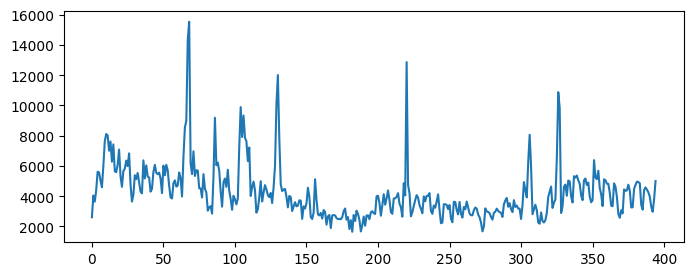

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(data_source)
plt.show()

## 訓練集

原始資料 (316, 1)
[[2178]
 [2917]
 [2357]]
原始資料2 (301, 1)
[[2178]
 [2917]
 [2357]]
還原原始資料 (301, 1)
[[3631.388859  ]
 [3639.25399655]]


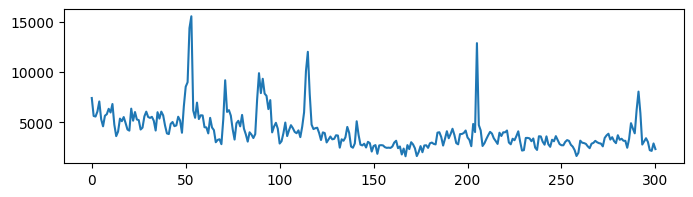

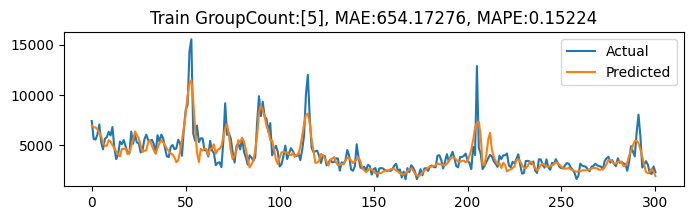

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39, 1)
[[5237]
 [5122]
 [5679]]
原始資料2 (24, 1)
[[5237]
 [5122]
 [5679]]
還原原始資料 (24, 1)
[[3911.13292997]
 [3916.92507234]]


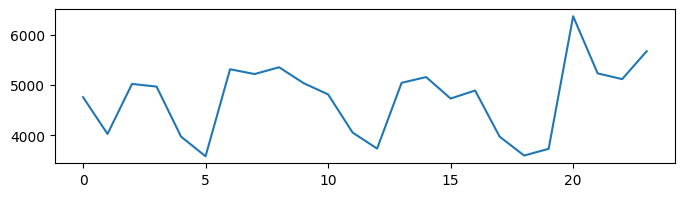

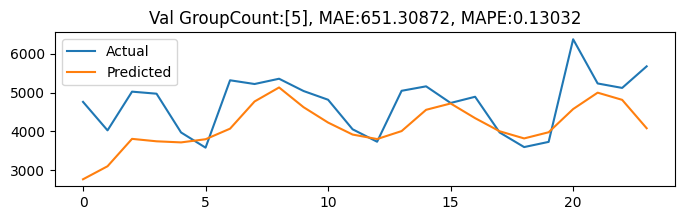

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40, 1)
[[2964]
 [3799]
 [5001]]
原始資料2 (25, 1)
[[2964]
 [3799]
 [5001]]
還原原始資料 (25, 1)
[[4038.02006576]
 [4037.92555604]]
Test GroupCount:[5], BatchSize:14, MAE:624.1015, MAPE:0.14857


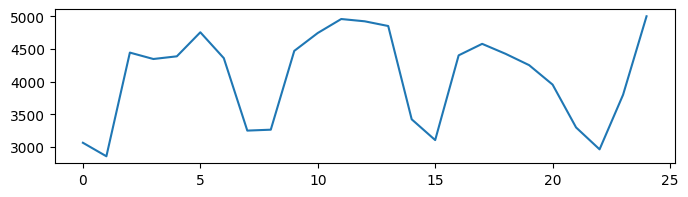

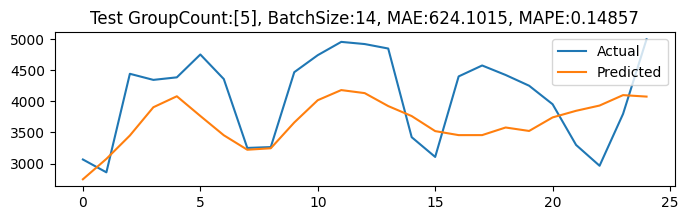

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'DecompEMD', 'labels': ['GroupCount'], 'model_type': 4, 'predicteds': [5], 'batch_size': 14, 'train_mae': 654.17276, 'train_mape': 0.15224, 'test_mae': 624.1015, 'test_mape': 0.14857, 'kfold': None, 'imfs': 7}
儲存評估結果到 DecompEMD/_Model/GroupCount_mt4_data5_batch14.result.json
